# Modified LeNet for AI-Generated Image Detection

This notebook implements a modified LeNet architecture specifically designed to detect AI-generated images. The classic LeNet-5 architecture will be significantly enhanced with modern CNN techniques to improve its ability to detect synthetic images.

## 1. Import Required Libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageChops, ImageEnhance
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
from tqdm.notebook import tqdm

# New imports for Hugging Face datasets
from datasets import load_dataset
import requests
from io import BytesIO

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Error Level Analysis (ELA) Preprocessing

Error Level Analysis (ELA) helps identify inconsistencies in compression artifacts, which is useful for detecting manipulated or AI-generated images.

In [4]:
import tempfile
import os

def error_level_analysis(img, quality=95):
    """Perform Error Level Analysis (ELA) on the input image"""
    try:
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)
            
        # Check image mode and convert if necessary
        if img.mode == 'RGBA':
            img = img.convert('RGB')
        elif img.mode == 'P' and 'transparency' in img.info:
            # Handle palette images with transparency
            img = img.convert('RGBA')
            img = img.convert('RGB')
        elif img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Use a secure temporary file with proper context handling
        with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as temp_file:
            temp_filename = temp_file.name
        
        # Save the image with a specific quality level to the temporary file
        img.save(temp_filename, 'JPEG', quality=quality)
        
        # Open the saved image
        saved_img = Image.open(temp_filename)
        
        # Calculate the difference between the original and resaved image
        ela_img = ImageChops.difference(img, saved_img)
        
        # Enhance the difference to make it more visible
        extrema = ela_img.getextrema()
        max_diff = max([ex[1] for ex in extrema]) if extrema else 0
        
        # Check for division by zero
        if max_diff <= 0:
            # If there's no difference, return the original image
            print("No ELA difference detected, returning original image")
            return img
            
        scale = 255.0 / max_diff
        
        ela_img = ImageEnhance.Brightness(ela_img).enhance(scale)
        
        # Make sure to close images and remove the temporary file
        saved_img.close()
        os.remove(temp_filename)
        
        return ela_img
    except Exception as e:
        # Print error details for debugging
        print(f"ELA processing error: {str(e)} - Using original image")
        return img  # Return the original image if processing fails

## 3. Loading and Processing the Hugging Face Dataset

We'll use the [Hemg/AI-Generated-vs-Real-Images-Datasets](https://huggingface.co/datasets/Hemg/AI-Generated-vs-Real-Images-Datasets) dataset from Hugging Face. This dataset contains real and AI-generated images for binary classification.

In [5]:
# login to huggingface in notebook
from huggingface_hub import notebook_login
notebook_login()

In [6]:
# Load the Hugging Face dataset
print("Loading dataset from Hugging Face...")
dataset = load_dataset("Hemg/AI-Generated-vs-Real-Images-Datasets")
print("Dataset loaded successfully!")

print("Loading dataset2 from Hugging Face...")
dataset2 = load_dataset("date3k2/raw_real_fake_images")
print("Dataset2 loaded successfully!")

# Display dataset structure
print("\nDataset Structure:")
print(dataset)

print("\nDataset2 Structure:")
print(dataset2)

Loading dataset from Hugging Face...
Dataset loaded successfully!
Loading dataset2 from Hugging Face...
Dataset loaded successfully!
Loading dataset2 from Hugging Face...
Dataset2 loaded successfully!

Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 152710
    })
})

Dataset2 Structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7444
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1862
    })
})
Dataset2 loaded successfully!

Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 152710
    })
})

Dataset2 Structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7444
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1862
    })
})


In [7]:
# Combine both datasets, shuffle them, and use for training
print("\n## Combining datasets")

# First, let's examine the label structure in both datasets
print("Dataset 1 features:")
print(dataset['train'].features)
print("\nDataset 2 features:")
print(dataset2['train'].features)

# Analyze label distribution of dataset 1
print("\nAnalyzing dataset 1 labels...")
label_counts_dataset1 = {}
sample_size = min(1000, len(dataset['train']))
indices = np.random.choice(len(dataset['train']), sample_size, replace=False)
subset = dataset['train'].select(indices)
label_column = subset['label']
for label in label_column:
    label_counts_dataset1[label] = label_counts_dataset1.get(label, 0) + 1
print(f"Dataset 1 label distribution (sample of {sample_size}):")
for label, count in label_counts_dataset1.items():
    print(f"Label {label}: {count} ({count/sample_size*100:.2f}%)")

# Analyze label distribution of dataset 2
print("\nAnalyzing dataset 2 labels...")
label_counts_dataset2 = {}
sample_size = min(1000, len(dataset2['train']))
indices = np.random.choice(len(dataset2['train']), sample_size, replace=False)
subset = dataset2['train'].select(indices)
label_column = subset['label']
for label in label_column:
    label_counts_dataset2[label] = label_counts_dataset2.get(label, 0) + 1
print(f"Dataset 2 label distribution (sample of {sample_size}):")
for label, count in label_counts_dataset2.items():
    print(f"Label {label}: {count} ({count/sample_size*100:.2f}%)")

print("\nPreparing dataset2 for combination...")

# Create new datasets with just the training data from dataset1
print(f"Dataset 1 size: {len(dataset['train'])} examples")

# Create a custom dataset for the combined data
from torch.utils.data import Dataset as TorchDataset

class CombinedDataset(TorchDataset):
    def __init__(self, dataset1, dataset2_train, dataset2_test=None):
        self.dataset1 = dataset1
        self.dataset2_train = dataset2_train
        self.dataset2_test = dataset2_test
        
        self.dataset1_len = len(dataset1)
        self.dataset2_train_len = len(dataset2_train)
        self.dataset2_test_len = len(dataset2_test) if dataset2_test else 0
        
        self.total_len = self.dataset1_len + self.dataset2_train_len + self.dataset2_test_len
        
    def __len__(self):
        return self.total_len
        
    def __getitem__(self, idx):
        if idx < self.dataset1_len:
            # Get from dataset1
            sample = self.dataset1[idx]
            return sample['image'], sample['label']
        elif idx < self.dataset1_len + self.dataset2_train_len:
            # Get from dataset2 train
            dataset2_idx = idx - self.dataset1_len
            sample = self.dataset2_train[dataset2_idx]
            return sample['image'], sample['label']
        else:
            # Get from dataset2 test
            dataset2_test_idx = idx - self.dataset1_len - self.dataset2_train_len
            sample = self.dataset2_test[dataset2_test_idx]
            return sample['image'], sample['label']

# Calculate sizes
dataset1_size = len(dataset['train'])
dataset2_train_size = len(dataset2['train'])
dataset2_test_size = len(dataset2['test']) if 'test' in dataset2 else 0
combined_size = dataset1_size + dataset2_train_size + dataset2_test_size

print(f"Dataset 1: {dataset1_size} examples")
print(f"Dataset 2 train: {dataset2_train_size} examples")
if 'test' in dataset2:
    print(f"Dataset 2 test: {dataset2_test_size} examples")
print(f"Combined dataset will have: {combined_size} examples")

# Create the combined dataset
combined_dataset = CombinedDataset(
    dataset['train'],
    dataset2['train'],
    dataset2['test'] if 'test' in dataset2 else None
)

print(f"\nCombined dataset created successfully with {len(combined_dataset)} examples.")
print("The combined dataset will be used for training.")

# Replace the train_data with the combined dataset to use it for training
train_data = combined_dataset


## Combining datasets
Dataset 1 features:
{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['AiArtData', 'RealArt'], id=None)}

Dataset 2 features:
{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Fake', 'Real'], id=None)}

Analyzing dataset 1 labels...
Dataset 1 label distribution (sample of 1000):
Label 1: 472 (47.20%)
Label 0: 528 (52.80%)

Analyzing dataset 2 labels...
Dataset 2 label distribution (sample of 1000):
Label 0: 436 (43.60%)
Label 1: 564 (56.40%)

Preparing dataset2 for combination...
Dataset 1 size: 152710 examples
Dataset 1: 152710 examples
Dataset 2 train: 7444 examples
Dataset 2 test: 1862 examples
Combined dataset will have: 162016 examples

Combined dataset created successfully with 162016 examples.
The combined dataset will be used for training.


## 3. Modified LeNet Architecture

Here, we implement our enhanced LeNet architecture with the following modifications:

1. Increased depth (8 convolutional layers)
2. Multiple filter sizes
3. Batch normalization
4. Dropout layers
5. Skip connections
6. Attention mechanism
7. Support for RGB inputs and larger image sizes

In [8]:
class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        attention_map = self.sigmoid(self.conv(x))
        return x * attention_map

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ModifiedLeNet(nn.Module):
    def __init__(self, num_classes=2, input_channels=3, input_size=256):
        super(ModifiedLeNet, self).__init__()
        
        # Calculate the size after convolutions and pooling
        # Assuming input_size is a power of 2 and >= 128
        final_size = input_size // 32  # After 5 max-pooling operations with stride 2
        
        # Initial convolution layer
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # First block with 64 filters
        self.block1 = ResidualBlock(64, 64)
        self.attention1 = AttentionModule(64)
        
        # Second block with 128 filters
        self.block2 = ResidualBlock(64, 128, stride=2)
        self.attention2 = AttentionModule(128)
        
        # Third block with 256 filters
        self.block3 = ResidualBlock(128, 256, stride=2)
        self.attention3 = AttentionModule(256)
        
        # Fourth block with 512 filters
        self.block4 = ResidualBlock(256, 512, stride=2)
        self.attention4 = AttentionModule(512)

        # Fully connected layers with dropout
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # Initial convolution
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        
        # Residual blocks with attention
        x = self.attention1(self.block1(x))
        x = self.attention2(self.block2(x))
        x = self.attention3(self.block3(x))
        x = self.attention4(self.block4(x))
        
        # Global average pooling and fully connected layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

# Create an instance of the model
model = ModifiedLeNet(num_classes=2, input_channels=3, input_size=256)
model = model.to(device)

# Display model architecture
print(model)

ModifiedLeNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (attention1): AttentionModule(
    (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    (sigmoid): Sigmoid()
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (b

## 4. Data Loading and Preprocessing

Set up data preprocessing pipelines and loaders. This section should be modified to point to your specific dataset location.

In [9]:
# Data transformations
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the ELAImageDataset class
class ELAImageDataset(Dataset):
    def __init__(self, root_dir=None, transform=None, apply_ela=True, ela_quality=95, huggingface_dataset=None):
        self.transform = transform
        self.apply_ela = apply_ela
        self.ela_quality = ela_quality
        self.huggingface_dataset = huggingface_dataset
        
        if huggingface_dataset is not None:
            # We're using a HuggingFace dataset
            self.dataset = huggingface_dataset
            self.classes = ['real', 'ai-generated']  # 0 for real, 1 for AI-generated
        else:
            # We're using a local dataset
            self.dataset = ImageFolder(root_dir)
            self.classes = self.dataset.classes
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        # Default fallback label - we'll set this to a more appropriate value if possible
        fallback_label = 0
        
        try:
            if self.huggingface_dataset is not None:
                # HuggingFace dataset format
                sample = self.dataset[idx]
                image = sample['image']
                label = sample['label']
                # Update fallback label when we know the actual label
                fallback_label = label
            else:
                # Local dataset format
                image, label = self.dataset[idx]
                # Update fallback label when we know the actual label
                fallback_label = label
            
            # Ensure image is in RGB mode (handle RGBA, palette or other formats)
            if isinstance(image, Image.Image):
                if image.mode == 'RGBA':
                    # Convert RGBA to RGB
                    image = image.convert('RGB')
                elif image.mode == 'P' and 'transparency' in image.info:
                    # Handle palette with transparency
                    image = image.convert('RGBA')
                    image = image.convert('RGB')
                elif image.mode != 'RGB':
                    # Convert any other format to RGB
                    image = image.convert('RGB')
            
            # Apply ELA if requested
            if self.apply_ela:
                try:
                    image = error_level_analysis(image, quality=self.ela_quality)
                except Exception as e:
                    # Just print error and continue with original image
                    print(f"ELA processing error for image {idx}: {e} - Using original image")
            
            # Apply transformations
            if self.transform is not None:
                image = self.transform(image)
                
            return image, label
            
        except Exception as e:
            print(f"Error processing image at index {idx}: {str(e)}")
            # Create an emergency fallback - a black image with the same label if we know it
            if self.transform is not None:
                # Create a black RGB image
                fallback = Image.new('RGB', (256, 256), color=0)
                fallback_tensor = self.transform(fallback)
                return fallback_tensor, fallback_label
            else:
                fallback = Image.new('RGB', (256, 256), color=0)
                return fallback, fallback_label

# Set a more conservative batch size and fewer workers to reduce errors
BATCH_SIZE = 16  # Smaller batch size
NUM_WORKERS = 1  # Use just one worker to avoid multiprocessing issues

# Print available splits in the dataset
print(f"Available dataset splits: {list(dataset.keys())}")

# Check if we need to create a validation split from the training data
if 'validation' not in dataset or len(dataset['validation']) == 0:
    print("No validation split found or validation split is empty. Creating validation set from train split...")
    # Calculate split sizes - use 80% for training, 20% for validation
    train_size = int(0.8 * len(dataset['train']))
    val_size = len(dataset['train']) - train_size
    
    # Split the training set
    train_val_dataset = dataset['train'].train_test_split(
        test_size=val_size, train_size=train_size, seed=42
    )
    
    # Create new datasets
    train_data = train_val_dataset['train']
    val_data = train_val_dataset['test']
    
    print(f"Split train dataset into {len(train_data)} training examples and {len(val_data)} validation examples")
else:
    # Use existing splits
    print("Using existing validation split")
    train_data = dataset['train']
    val_data = dataset['validation']

# Set up for training with the combined Hugging Face dataset
train_dataset = ELAImageDataset(
    huggingface_dataset=train_data, 
    transform=transform_train,
    apply_ela=True,
    ela_quality=95
)

val_dataset = ELAImageDataset(
    huggingface_dataset=val_data, 
    transform=transform_test,
    apply_ela=True,
    ela_quality=95
)

# Check if test split exists
if 'test' in dataset:
    test_dataset = ELAImageDataset(
        huggingface_dataset=dataset['test'], 
        transform=transform_test,
        apply_ela=True,
        ela_quality=95
    )
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if torch.cuda.is_available() else False)
    print(f"Test samples: {len(test_dataset)}")
else:
    print("No test split found. Using validation set for testing.")
    test_dataset = val_dataset
    test_loader = None

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS, 
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=False,  # Avoid persistent workers to prevent memory issues
    drop_last=True  # Drop the last incomplete batch to avoid size issues
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=False,  # Avoid persistent workers to prevent memory issues
    drop_last=False  # Keep all samples for validation
)

if test_loader is None and 'test' not in dataset:
    test_loader = val_loader

# Print dataset information
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Classes: {train_dataset.classes}")

Available dataset splits: ['train']
No validation split found or validation split is empty. Creating validation set from train split...
Split train dataset into 122168 training examples and 30542 validation examples
No test split found. Using validation set for testing.
Training samples: 122168
Validation samples: 30542
Classes: ['real', 'ai-generated']


## 5. Training Functions

In [10]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': running_loss / (progress_bar.n + 1),
            'acc': 100. * correct / total
        })
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    return train_loss, train_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation")
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Track statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Store predictions and targets for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': running_loss / (progress_bar.n + 1),
                'acc': 100. * correct / total
            })
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    
    # Calculate additional metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='binary')
    
    return val_loss, val_acc, precision, recall, f1, all_targets, all_preds

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, save_path="model_best.pth"):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train one epoch
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc, precision, recall, f1, _, _ = validate(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)
        
        # Print statistics
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            print(f"Validation accuracy improved from {best_val_acc:.2f}% to {val_acc:.2f}%. Saving model...")
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
    
    return model, history

## 6. Define Loss Function, Optimizer, and Learning Rate Scheduler

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/home/icarus/miniconda3/envs/school/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 7. Train the Model

Uncomment and run this section when your dataset is ready.

In [12]:
# Define number of training epochs
num_epochs = 1

# Train the model
trained_model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    save_path="modified_lenet_best.pth"
)


Epoch 1/1


Training:   0%|          | 0/7635 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 8. Visualize Training History

In [13]:
# First, make sure we have history data to visualize
if 'history' in globals() and history:
    # Check if history contains data
    print(f"History contains {len(history['train_acc'])} epochs of data")
    
    # Convert data to lists if they aren't already
    epochs = list(range(1, len(history['train_acc']) + 1))
    train_acc = [float(x) for x in history['train_acc']]
    val_acc = [float(x) for x in history['val_acc']]
    train_loss = [float(x) for x in history['train_loss']]
    val_loss = [float(x) for x in history['val_loss']]
    precision = [float(x) for x in history['precision']]
    recall = [float(x) for x in history['recall']]
    f1 = [float(x) for x in history['f1']]
    
    print("Training accuracy values:", train_acc)
    print("Validation accuracy values:", val_acc)
    
    # Create a simple figure for accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'bo-')
    plt.plot(epochs, val_acc, 'ro-')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.grid(True)
    
    # Create a simple figure for loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'bo-')
    plt.plot(epochs, val_loss, 'ro-')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Create a simple figure for precision, recall, and F1
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, precision, 'go-', label='Precision')
    plt.plot(epochs, recall, 'mo-', label='Recall')
    plt.plot(epochs, f1, 'co-', label='F1')
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print the final metrics
    print(f"Final training metrics after {len(history['train_acc'])} epochs:")
    print(f"Training accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"Validation accuracy: {history['val_acc'][-1]:.2f}%")
    print(f"F1 Score: {history['f1'][-1]:.4f}")
    print(f"Precision: {history['precision'][-1]:.4f}")
    print(f"Recall: {history['recall'][-1]:.4f}")
else:
    print("No training history data available. Please train the model first.")
    print("Run the training cell to generate history data.")

# If you still don't see lines, try plotting with matplotlib directly
if 'history' in globals() and history:
    # Direct access to matplotlib for troubleshooting
    import matplotlib.pyplot as plt
    
    # Create a very simple plot to verify matplotlib is working
    plt.figure(figsize=(8, 6))
    plt.plot([1, 2, 3, 4], [10, 20, 25, 30], 'ro-')
    plt.title('Verification Plot')
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.grid(True)
    plt.show()
    
    # If you want to check the actual values being plotted
    print("\nRaw history data for debugging:")
    for i, (ta, va, tl, vl, p, r, f) in enumerate(zip(
            history['train_acc'], history['val_acc'], 
            history['train_loss'], history['val_loss'],
            history['precision'], history['recall'], history['f1']
        )):
        print(f"Epoch {i+1}: Train Acc={ta:.2f}%, Val Acc={va:.2f}%, Train Loss={tl:.4f}, Val Loss={vl:.4f}, P={p:.4f}, R={r:.4f}, F1={f:.4f}")

No training history data available. Please train the model first.
Run the training cell to generate history data.


## 9. Evaluate Model on Test Set and Create Confusion Matrix

Evaluating model on test dataset...


Validation:   0%|          | 0/1909 [00:00<?, ?it/s]


Test Results:
Accuracy: 65.03%
Precision: 0.7181
Recall: 0.4171
F1 Score: 0.5277


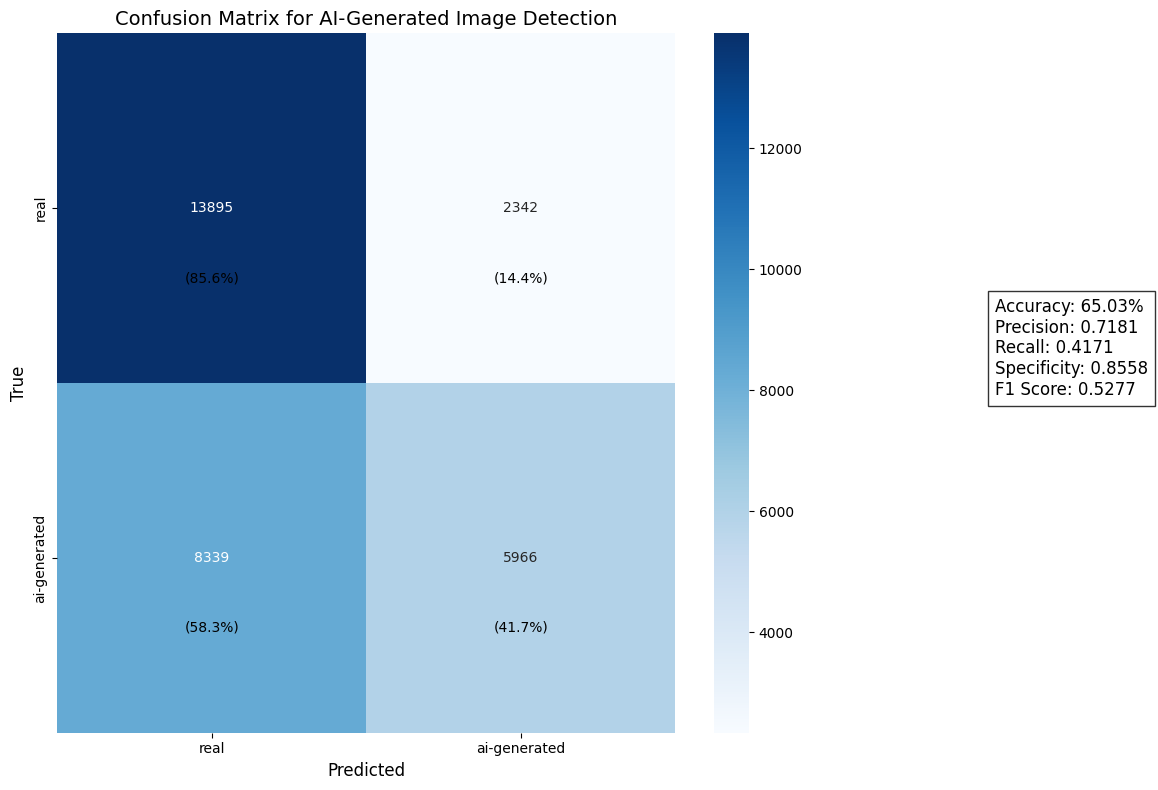


Metrics for class 'real':
Precision: 0.6249
Recall: 0.8558
F1 Score: 0.7224

Metrics for class 'ai-generated':
Precision: 0.7181
Recall: 0.4171
F1 Score: 0.5277


In [14]:
# Evaluate model on test set and create confusion matrix
# Load the best model
model.load_state_dict(torch.load("modified_lenet_best.pth"))
model.eval()

# We already have test_loader and test_dataset defined earlier
# No need to recreate them unless you want to use a different test dataset
print("Evaluating model on test dataset...")

# Evaluate on test set
test_loss, test_acc, test_precision, test_recall, test_f1, y_true, y_pred = validate(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"Accuracy: {test_acc:.2f}%")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a more visually appealing confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix for AI-Generated Image Detection', fontsize=14)

# Add text annotations with percentages
total = np.sum(cm)
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j + 0.5, i + 0.7, f'({cm[i][j]/np.sum(cm[i]):.1%})', 
                 ha='center', va='center', fontsize=10, color='black')

# Calculate and display metrics derived from confusion matrix
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

metrics_text = (f"Accuracy: {test_acc:.2f}%\n"
                f"Precision: {test_precision:.4f}\n"
                f"Recall: {test_recall:.4f}\n"
                f"Specificity: {specificity:.4f}\n"
                f"F1 Score: {test_f1:.4f}")

plt.figtext(1.0, 0.5, metrics_text, fontsize=12, ha="left", 
            bbox={"facecolor":"white", "alpha":0.8, "pad":5})

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# Print class-wise metrics
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(y_true, y_pred)
for i, class_name in enumerate(test_dataset.classes):
    print(f"\nMetrics for class '{class_name}':")
    print(f"Precision: {precision_per_class[i]:.4f}")
    print(f"Recall: {recall_per_class[i]:.4f}")
    print(f"F1 Score: {f1_per_class[i]:.4f}")

## 10. Visualize Feature Maps to Understand What the Model is Learning

Selected random image #6961 with true label: Real


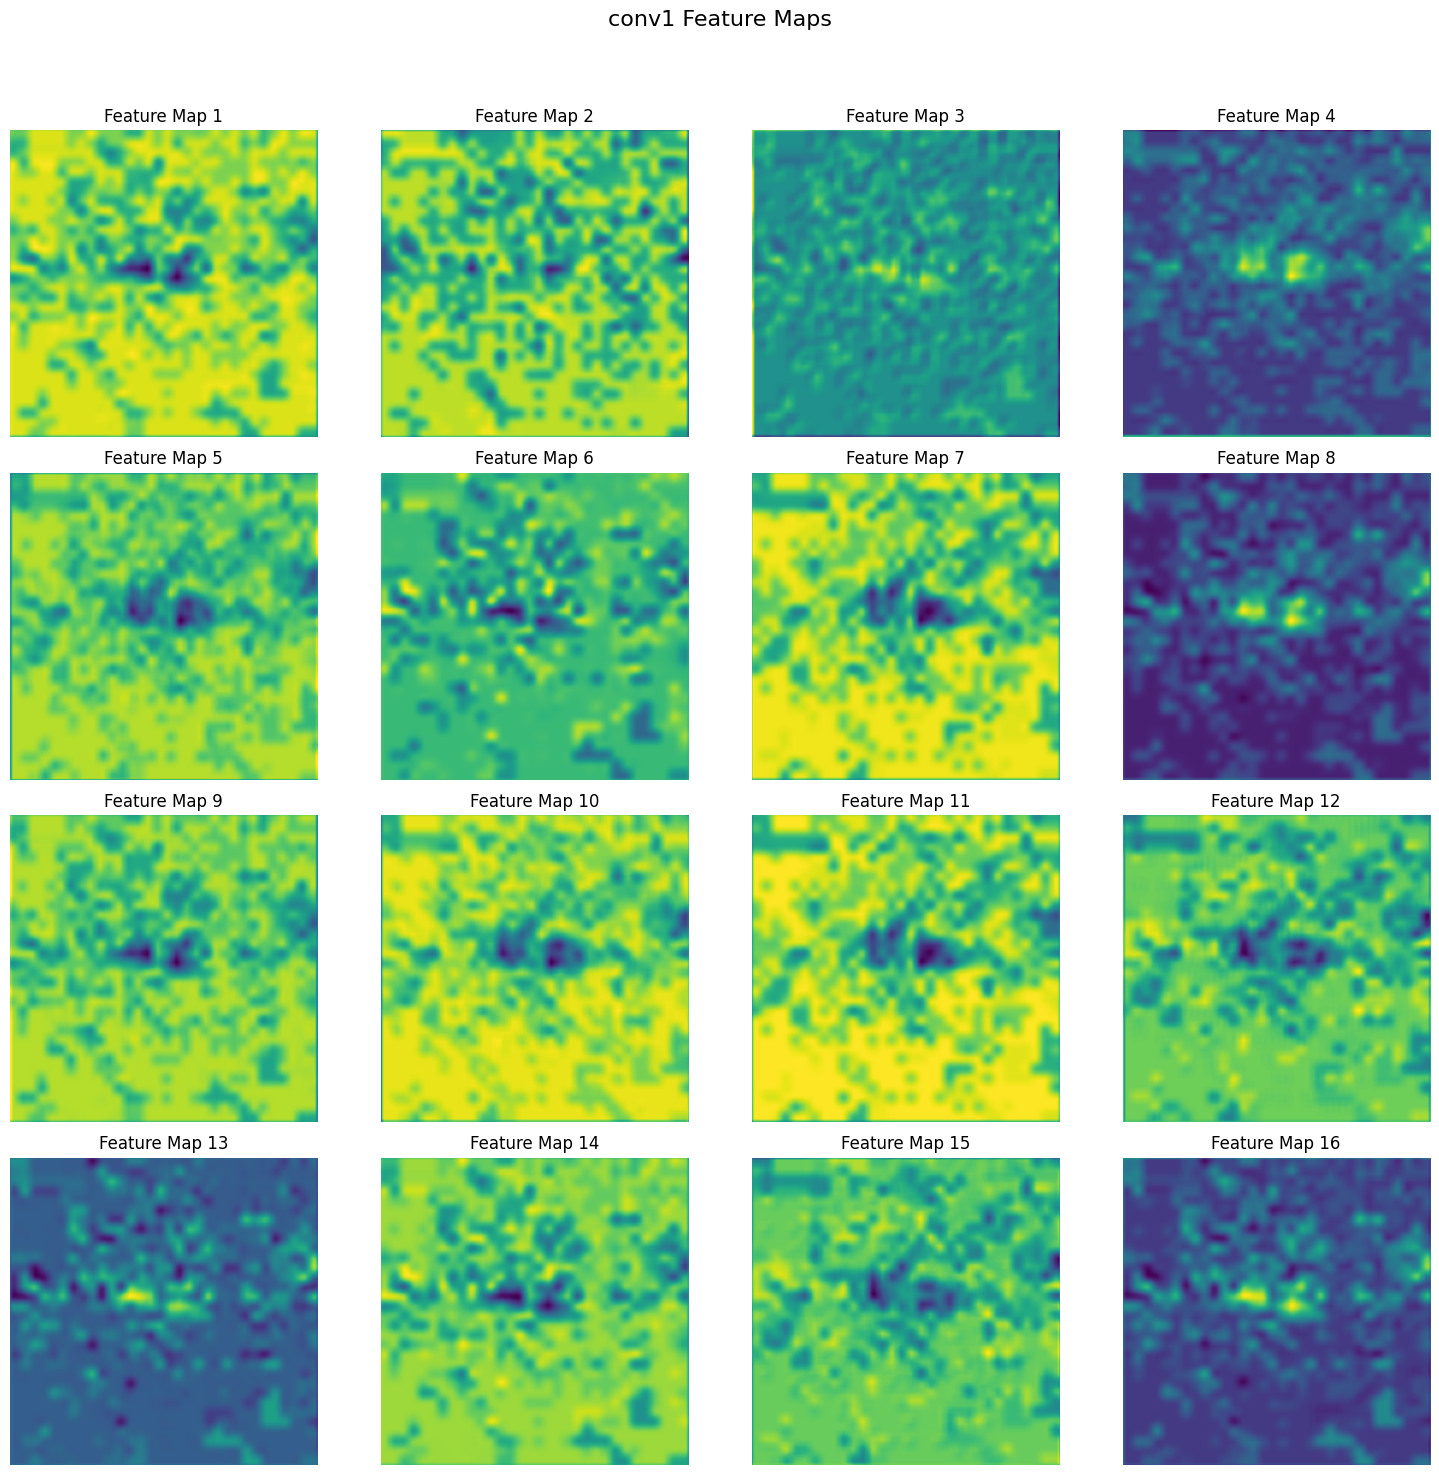

Model prediction: Real


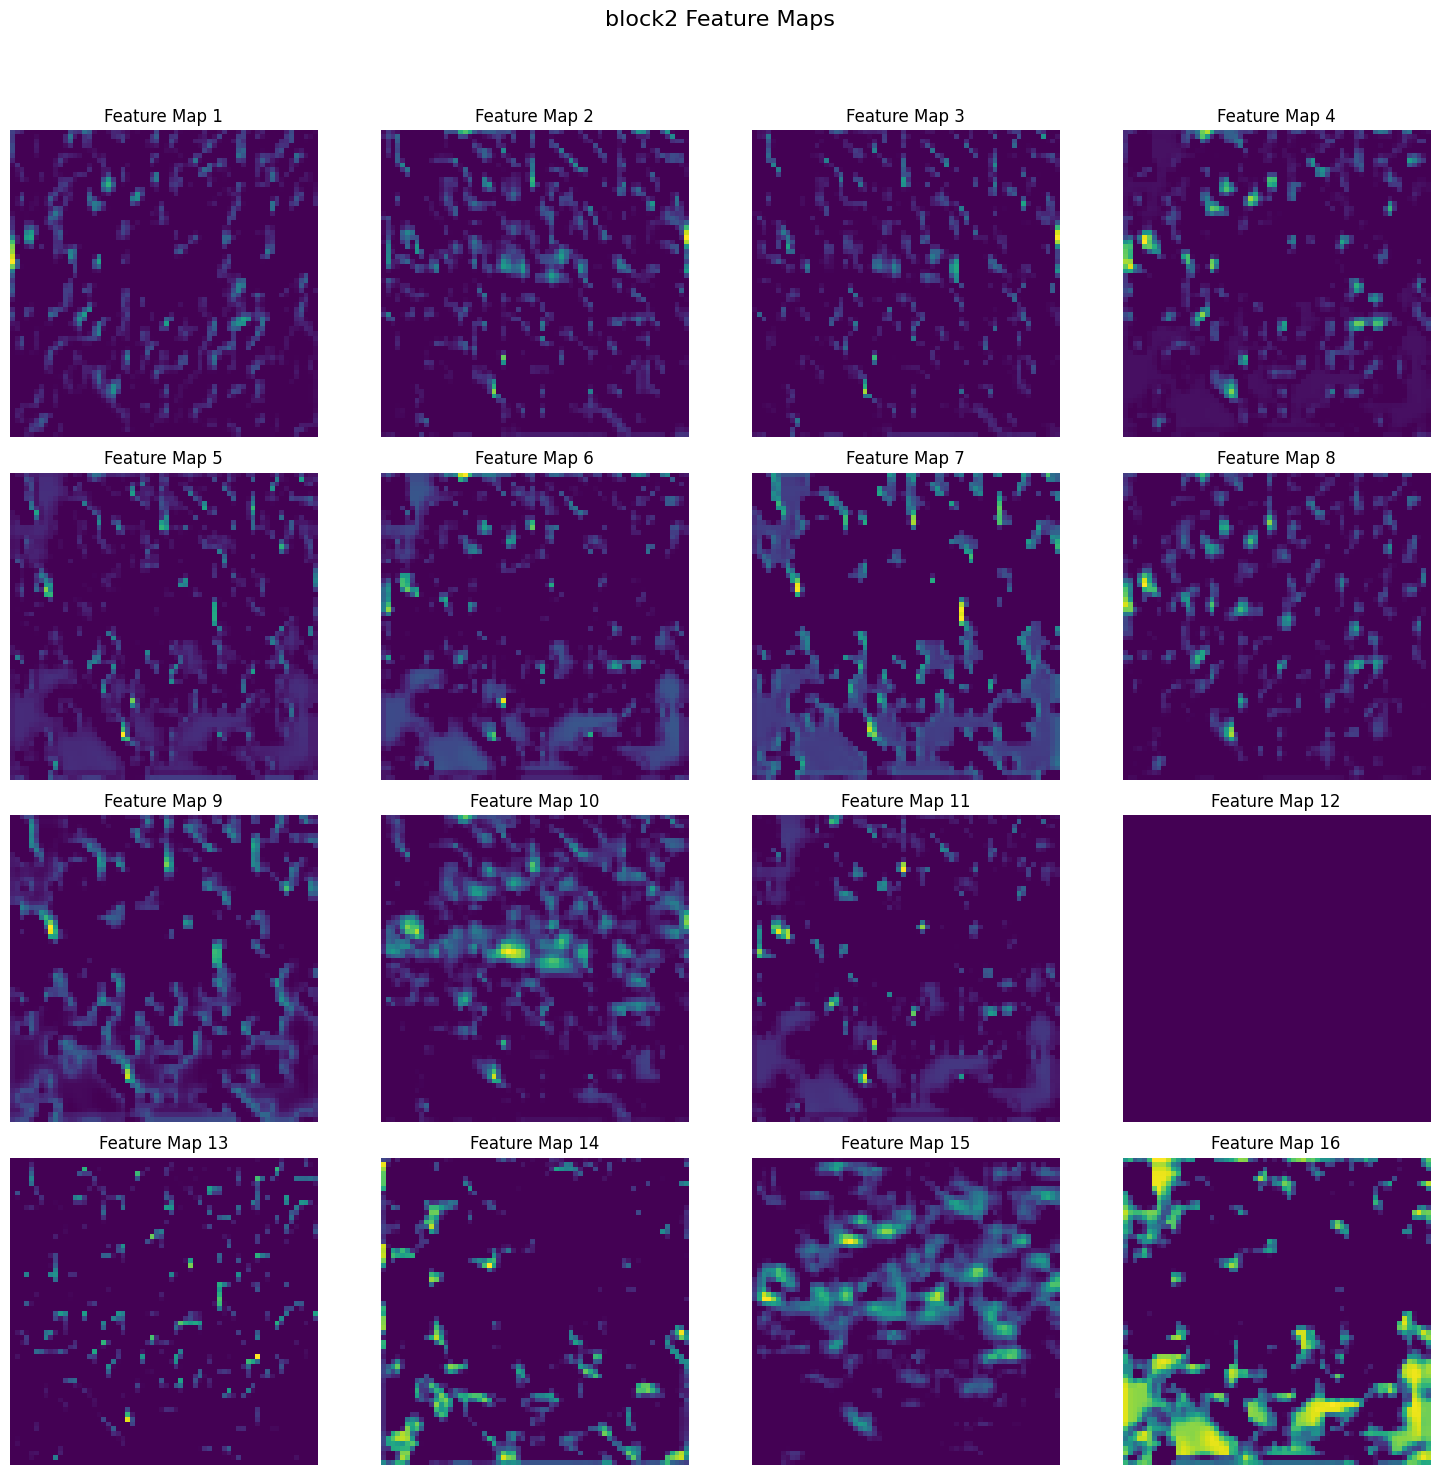

In [15]:
# Function to visualize feature maps
def visualize_feature_maps(model, image_tensor=None, image_path=None, device=device, layer_name="conv1"):
    """
    Visualize feature maps from the model for a given image
    
    Args:
        model: The trained model
        image_tensor: Optional pre-loaded image tensor
        image_path: Optional path to an image file
        device: Device to run the model on
        layer_name: Name of the layer to visualize
    """
    # Create a hook to get feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    # Register hook
    if layer_name == "conv1":
        model.conv1.register_forward_hook(get_activation('conv1'))
    elif layer_name == "block1":
        model.block1.register_forward_hook(get_activation('block1'))
    elif layer_name == "block2":
        model.block2.register_forward_hook(get_activation('block2'))
    
    # Process the image
    if image_tensor is not None:
        # Use provided tensor
        input_tensor = image_tensor.unsqueeze(0).to(device) if image_tensor.dim() == 3 else image_tensor.to(device)
        original_image = None
    elif image_path is not None:
        # Load and preprocess image from path
        image = Image.open(image_path).convert('RGB')
        # Apply ELA
        ela_image = error_level_analysis(image)
        # Apply transformations
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        input_tensor = transform(ela_image).unsqueeze(0).to(device)
        original_image = image
        processed_image = ela_image
    else:
        raise ValueError("Either image_tensor or image_path must be provided")
    
    # Forward pass
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
    
    # Get feature maps
    feature_maps = activation[layer_name].squeeze().cpu()
    
    # Plot original and processed image if available
    if original_image is not None:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(processed_image)
        plt.title('ELA Processed Image')
        plt.axis('off')
        
        plt.suptitle(f"Prediction: {'AI-Generated' if pred == 1 else 'Real'}", fontsize=16)
        plt.tight_layout()
        plt.show()
    
    # Plot feature maps
    num_maps = min(16, feature_maps.size(0))  # Display up to 16 feature maps
    plt.figure(figsize=(15, 15))
    
    for i in range(num_maps):
        plt.subplot(4, 4, i + 1)
        plt.imshow(feature_maps[i], cmap='viridis')
        plt.title(f'Feature Map {i+1}')
        plt.axis('off')
        
    plt.suptitle(f"{layer_name} Feature Maps", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    return pred

# Example usage - uncomment to visualize feature maps
# Load model first
model.load_state_dict(torch.load("modified_lenet_best.pth"))
model.eval()

# Get a random image from the test dataset
def get_random_image_from_dataset(dataset):
    """Get a random image from the dataset"""
    idx = np.random.randint(0, len(dataset))
    image, label = dataset[idx]
    return image, label, idx

# Visualize feature maps using a random image from the dataset
image_tensor, true_label, img_idx = get_random_image_from_dataset(test_dataset)
print(f"Selected random image #{img_idx} with true label: {'AI-Generated' if true_label == 1 else 'Real'}")

# Visualize feature maps for this image
pred_label = visualize_feature_maps(model, image_tensor=image_tensor, layer_name="conv1")
print(f"Model prediction: {'AI-Generated' if pred_label == 1 else 'Real'}")

# Visualize deeper layers for the same image
_ = visualize_feature_maps(model, image_tensor=image_tensor, layer_name="block2")

## 11. Model Inference Function for New Images

We'll implement functions to allow file uploads to the notebook and use our model to predict if uploaded images are real or AI-generated.

In [25]:
from IPython.display import display
import ipywidgets as widgets
import io

def predict_image(model, image_path=None, image_pil=None, device=device, apply_ela=True, display_results=True):
    """Make prediction on an image using the model
    
    Args:
        model: The trained model
        image_path: Path to the image file (optional)
        image_pil: PIL Image object (optional)
        device: Device to run inference on
        apply_ela: Whether to apply Error Level Analysis
        
    Returns:
        tuple: (prediction, confidence)
    """
    # Load image from path or use provided PIL image
    if image_pil is not None:
        image = image_pil
    elif image_path is not None:
        image = Image.open(image_path).convert('RGB')
    else:
        raise ValueError("Either image_path or image_pil must be provided")
    
    # Store original image for display
    original_image = image.copy()
    
    # Apply ELA if requested
    if apply_ela:
        ela_image = error_level_analysis(image)
    else:
        ela_image = image
    
    # Apply transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(ela_image).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    # Get prediction and confidence
    prediction = "AI-Generated" if predicted.item() == 1 else "Real"
    confidence = probabilities[0][predicted.item()].item() * 100
    
    if display_results:
        # Display results with both original and ELA images
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(ela_image)
        plt.title('ELA Processed Image')
        plt.axis('off')
        
        plt.suptitle(f"Prediction: {prediction} (Confidence: {confidence:.2f}%)", fontsize=16)
        plt.tight_layout()
        plt.show()
    
    
    return prediction, confidence, probabilities[0].cpu().numpy()

# File upload widget for images
def create_upload_widget():
    upload_widget = widgets.FileUpload(
        accept='.jpg,.jpeg,.png',
        multiple=False,
        description='Upload Image:',
        style={'description_width': 'initial'},
        button_style='info'
    )
    return upload_widget

def on_upload_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        # Get the uploaded file - handle both dictionary and tuple formats
        if not change['new']:
            # Empty upload
            return
            
        try:
            # First try to handle it as a dictionary
            if isinstance(change['new'], dict):
                uploaded_file = list(change['new'].values())[0]
            else:
                # If it's not a dict, it might be a tuple/list format
                uploaded_file = change['new'][0]
                
            # Convert to PIL Image
            image_data = uploaded_file['content']
            image_pil = Image.open(io.BytesIO(image_data)).convert('RGB')
            
            # Display progress message
            print("Image uploaded! Processing...")
            
            # Make prediction
            prediction, confidence, class_probs = predict_image(model, image_pil=image_pil)
            
            # Print detailed results
            print(f"Prediction: {prediction} with {confidence:.2f}% confidence")
            print(f"Class probabilities: Real: {class_probs[0]*100:.2f}%, AI-Generated: {class_probs[1]*100:.2f}%")
            
        except Exception as e:
            print(f"Error processing image: {str(e)}")
            print("Please try uploading a different image.")
            
        # Reset widget to allow another upload
        # change['owner'].value = {}

# Create interactive widget for image upload and prediction
def setup_interactive_prediction():
    # Make sure the model is loaded
    try:
        model.load_state_dict(torch.load("modified_lenet_best.pth"))
        model.eval()
        print("Model loaded successfully from 'modified_lenet_best.pth'")
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        print("Using current model state instead")
    
    # Create upload widget
    upload_widget = create_upload_widget()
    
    # Register callback
    upload_widget.observe(on_upload_change, names='value')
    
    # Display instructions and widget
    print("Upload an image to detect if it's real or AI-generated.")
    print("The model will process the image and show the prediction results.")
    display(upload_widget)
    
    return upload_widget

In [17]:
# Setup and display the interactive prediction widget
upload_widget = setup_interactive_prediction()

Model loaded successfully from 'modified_lenet_best.pth'
Upload an image to detect if it's real or AI-generated.
The model will process the image and show the prediction results.


FileUpload(value=(), accept='.jpg,.jpeg,.png', button_style='info', description='Upload Image:')

### Test with Random Images from Dataset

You can also test the model on random images from the test dataset.

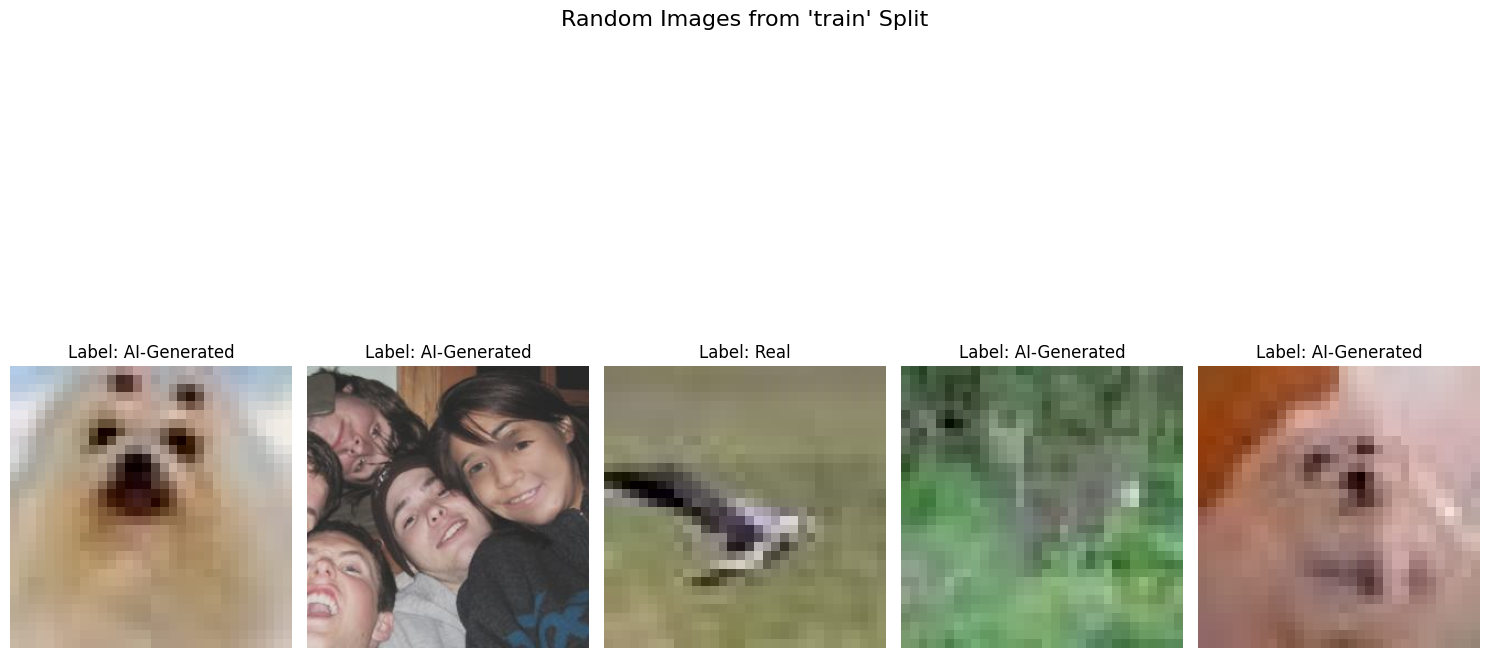

In [18]:
def get_random_image(dataset, split):
    """Get random images from the dataset for visualization"""
    if split not in dataset:
        raise ValueError(f"Split '{split}' not found in dataset")
    
    idx = np.random.randint(0, len(dataset[split]))
    example = dataset[split][idx]
    
    return example['image'], example['label']

def visualize_random_images(dataset, split, num_images=5):
    """Visualize random images from the dataset"""
    
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        
        image, label = get_random_image(dataset, split)
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {'AI-Generated' if label == 1 else 'Real'}")
        plt.axis('off')
    
    plt.suptitle(f"Random Images from '{split}' Split", fontsize=16)
    plt.tight_layout()
    plt.show()
    
# Visualize random images from the training set
visualize_random_images(dataset, 'train', num_images=5)

Testing on 5 random images from the test dataset...


<Figure size 1500x1000 with 0 Axes>

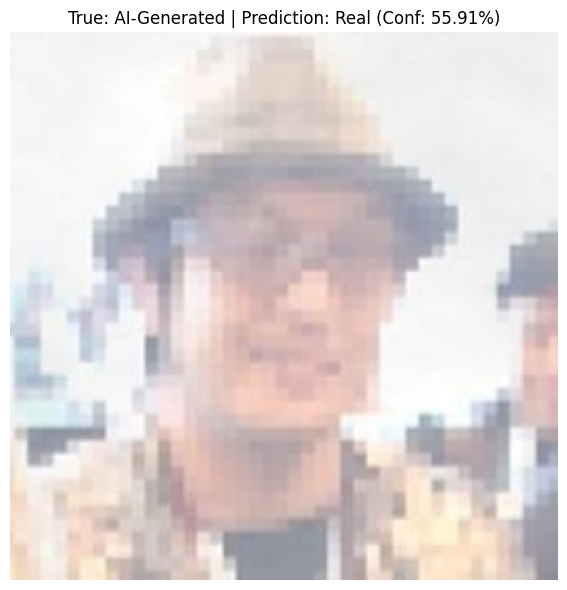

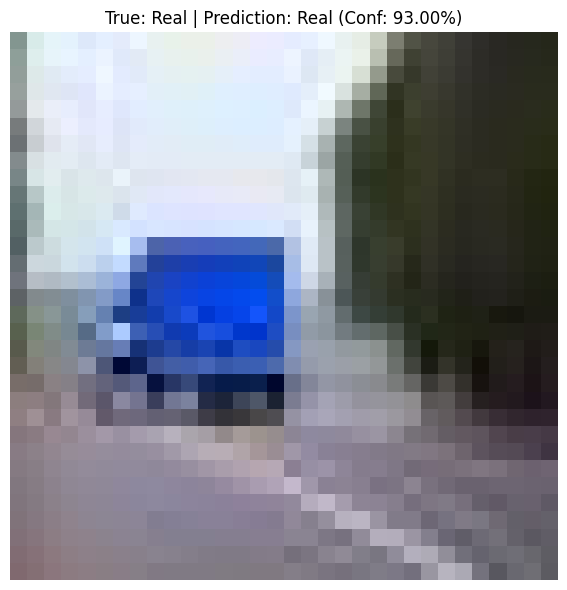

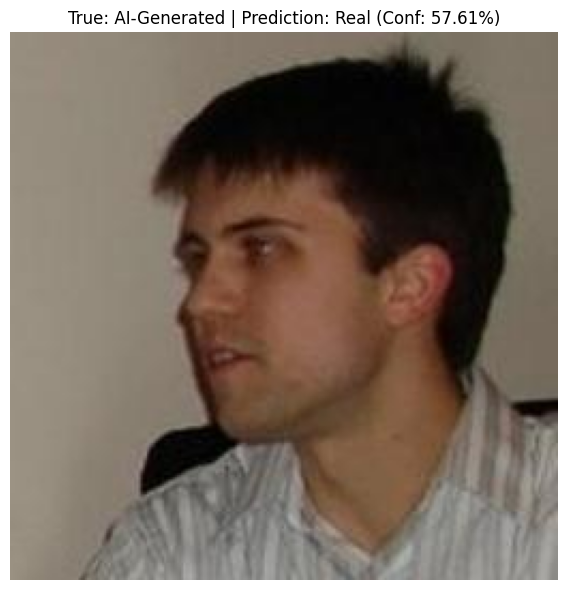

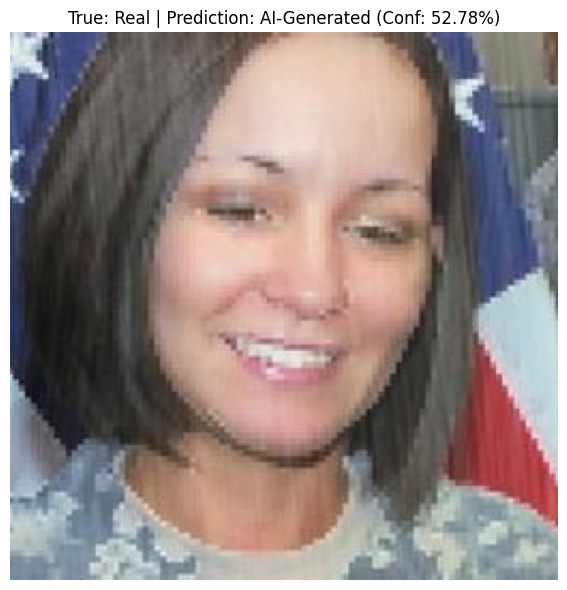

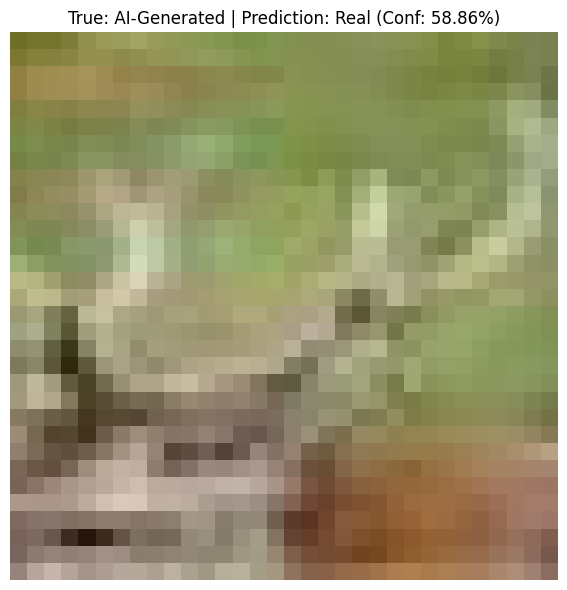

,True Label,Prediction,Confidence,Correct
0,AI-Generated,Real,55.91%,False
1,Real,Real,93.00%,True
2,AI-Generated,Real,57.61%,False
3,Real,AI-Generated,52.78%,False
4,AI-Generated,Real,58.86%,False



Accuracy on random sample: 20.00%


In [ ]:
def test_on_random_images(num_images=30):
    


    # Define the grid layout - 6 rows and 5 columns
    num_rows = 6
    num_cols = 5
    
    # Create figure with multiple subplots arranged in a grid
    plt.figure(figsize=(20, 24))  # Larger figure size to accommodate the grid
    
    # Process multiple random images
    for i in range(num_images):
        # Get random image
        pil_image, true_label = get_random_image(dataset, "train")
        
        true_class = "AI-Generated" if true_label == 1 else "Real"
        
        # Convert to tensor and apply transformations
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        image_tensor = transform(pil_image).unsqueeze(0).to(device)
        
        # Make prediction
        prediction, confidence, class_probs = predict_image(model, image_pil=pil_image, display_results=False)
        
        # Add subplot to the grid
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(pil_image)
        plt.title(f"True: {true_class}\nPred: {prediction}\n{confidence:.1f}%", fontsize=9)
        plt.axis('off')
        
        # Color the title based on correct/incorrect prediction
        if prediction == true_class:
            plt.gca().set_title(plt.gca().get_title(), color='green')
        else:
            plt.gca().set_title(plt.gca().get_title(), color='red')
        
        # Store results
        results.append({
            'True Label': true_class,
            'Prediction': prediction,
            'Confidence': f"{confidence:.2f}%,
            'Correct': prediction == true_class
        })
    
    # Add a main title and adjust spacing
    plt.suptitle("Model Predictions on Random Test Images", fontsize=16, y=0.92)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.tight_layout()
    plt.show()
    
    # Display results table
    df_results = pd.DataFrame(results)
    display(df_results)
    
    # Calculate accuracy
    accuracy = df_results['Correct'].mean() * 100
    print(f"\nAccuracy on random sample: {accuracy:.2f}%")
    
    # Create a confusion matrix from our sample
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(df_results['True Label'], df_results['Prediction'], labels=["Real", "AI-Generated"])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Real", "AI-Generated"],
                yticklabels=["Real", "AI-Generated"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix on Sample Images')
    plt.tight_layout()
    plt.show()

    # Display class-wise results
    for label in df_results['True Label'].unique():
        subset = df_results[df_results['True Label'] == label]
        accuracy = (subset['Correct'].sum() / len(subset)) * 100
        print(f"Accuracy for {label}: {accuracy:.2f}%")

test_on_random_images(num_images=30)

## 13. Conclusion

In this notebook, we've implemented a modified LeNet architecture specifically for AI-generated image detection. The key modifications include:

1. Increased network depth (8 convolutional layers vs. the original 2)
2. Added residual connections for better gradient flow
3. Incorporated attention mechanisms to focus on suspicious regions
4. Utilized Error Level Analysis (ELA) as an additional preprocessing step
5. Implemented dropout and batch normalization for better regularization
6. Expanded input size to 256×256 RGB (vs. original 32×32 grayscale)
7. Modified the output for binary classification (real vs. AI-generated)

This architecture should provide a strong baseline for detecting AI-generated images. For best results, the model should be trained on a diverse dataset containing various types of AI-generated content across multiple GAN architectures.